In [1]:
import pandas as pd
import numpy as np
import math
from functools import reduce
import datetime 


import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv("Z://00_ETL/return_rates/return_rates_content_3.txt", sep= "\t")

In [3]:
print(df.shape, df['encrypted_customer_id'].nunique())
df.head()

(13198200, 7) 1499999


,transaction_date_local,encrypted_customer_id,units,rank,content_type_named,marketplace_id,revenue
0,2015-01-16,A04735111CU5CGAC9AMRX,2,1,TV Episode,3,2.82
1,2016-08-27,A04785912CKUXCK2143AW,1,1,TV Episode,3,1.58
2,2016-09-01,A04785912CKUXCK2143AW,1,2,TV Season,3,6.66
3,2016-10-16,A04785912CKUXCK2143AW,1,3,Movie EST,3,4.99
4,2016-10-21,A04785912CKUXCK2143AW,1,4,TV Season,3,9.16


##  Distribution by first transaction

In [4]:
df['content_type_named'].unique()

array(['TV Episode', 'TV Season', 'Movie EST', 'Movie VOD', 'Unknown'], dtype=object)

In [5]:
print("Number of unique customers who purchased VOD as their first transaction:" ,
df[(df['content_type_named'] == 'Movie VOD') & (df['rank'] == 1)]['encrypted_customer_id'].nunique(),
"out of ",df['encrypted_customer_id'].nunique())


Number of unique customers who purchased VOD as their first transaction: 728227 out of  1499999


In [6]:
def subset_and_preprocess(df,content):
    """function subsets by content and makes preparations for first couple of transactions"""
    t = df[(df['content_type_named'] == content) & (df['rank'] == 1)]
    m = df[df['encrypted_customer_id'].isin(t['encrypted_customer_id'])]
    
    #create subset and pivot to group into only VOD and mixed customers
    z = m[['encrypted_customer_id','units','content_type_named']]
    r = pd.pivot_table(z, index="encrypted_customer_id",columns = 'content_type_named',
                  values = "units",aggfunc='sum').reset_index()
    r = r.fillna(0)
    r['total'] = r['Movie EST'] + r['Movie VOD'] + r['TV Episode'] + r['Unknown']
    r['is_VOD_only'] = np.where((r['total'] == r['Movie VOD']),1,0)
    
    f = pd.merge(left=m,right=r[["encrypted_customer_id",'is_VOD_only']],
                 left_on="encrypted_customer_id",right_on="encrypted_customer_id",how="left")
       
    return f

In [7]:
t = subset_and_preprocess(df,"Movie VOD")

In [8]:
print(t['encrypted_customer_id'].nunique())
t.shape

728227


(6509988, 8)

In [9]:
def add_max_rank(df):
    """add max rank"""
    t = pd.DataFrame(df.groupby("encrypted_customer_id")['rank'].max().reset_index())
    t.columns = ['encrypted_customer_id','max_rank']
    
    m = pd.merge(left=df,right=t,
                 left_on='encrypted_customer_id', right_on='encrypted_customer_id', how = 'left')
    return m


def add_dates_to_df(df):
    """the function calculates first 5 purchase dates for each customer and appends to the initial dataset"""
    #df_r['rank'] = df_r.groupby('encrypted_customer_id')['transaction_date_local'].rank(ascending=True) #takes really long
    
    dataframe = []
    for i in range(0,11):
        #give the range of time differences
        
        t = pd.DataFrame(df.groupby("encrypted_customer_id")['transaction_date_local'].nth(i).reset_index()) 
    #k = t.iloc[:,1]
    #df['col%d' %i] = pd.merge(left=df,right=t,left_on='encrypted_customer_id',right_on='encrypted_customer_id', how='left')
        dataframe.append(t)
    
    temp = reduce(lambda x,y:pd.merge(x,y,on = 'encrypted_customer_id',how='outer'), dataframe)   
    new = pd.merge(df,temp,on = 'encrypted_customer_id', how = 'left' )

    new.columns = ['transaction_date','encrypted_customer_id','units','rank','content_type',
                  'marketplace_id','revenue', 'is_VOD_only','max_rank',
                  'first_date','second_date','third_date','fourth_date','fifth_date','sixth_date','seven_date',
                  'eighth_date','ninth_date','tenth_date','eleventh_date']
    
    return new

In [10]:
t = add_max_rank(t)
t = add_dates_to_df(t)

In [11]:
def calculate_time_diff(df):
    """convert time to datetime object and get diff in days"""
    df['transaction_date'] = pd.to_datetime(df['transaction_date'])
    df['first_date']       = pd.to_datetime(df['first_date'])
    df['second_date']      = pd.to_datetime(df['second_date'])
    df['third_date']       = pd.to_datetime(df['third_date'])
    df['fourth_date']      = pd.to_datetime(df['fourth_date'])
    df['fifth_date']       = pd.to_datetime(df['fifth_date'])
    df['sixth_date']       = pd.to_datetime(df['sixth_date'])
    df['seven_date']       = pd.to_datetime(df['seven_date'])
    df['eighth_date']      = pd.to_datetime(df['eighth_date'])
    df['ninth_date']       = pd.to_datetime(df['ninth_date'])
    df['tenth_date']       = pd.to_datetime(df['tenth_date'])
    df['eleventh_date']    = pd.to_datetime(df['eleventh_date'])
    
    
    
    
    df['diff_vs_first']    = (df['transaction_date'] - df['first_date']) / np.timedelta64(1,"D")
    df['diff_vs_second']   = (df['transaction_date'] - df['second_date']) / np.timedelta64(1,"D")
    df['diff_vs_third']    = (df['transaction_date'] - df['third_date']) / np.timedelta64(1,"D")
    df['diff_vs_fourth']   = (df['transaction_date'] - df['fourth_date']) / np.timedelta64(1,"D")
    df['diff_vs_fifth']    = (df['transaction_date'] - df['fifth_date']) / np.timedelta64(1,"D")
    df['diff_vs_sixth']    = (df['transaction_date'] - df['sixth_date']) / np.timedelta64(1,"D")
    df['diff_vs_seventh']  = (df['transaction_date'] - df['seven_date']) / np.timedelta64(1,"D")
    df['diff_vs_eighth']   = (df['transaction_date'] - df['eighth_date']) / np.timedelta64(1,"D")
    df['diff_vs_ninth']    = (df['transaction_date'] - df['ninth_date']) / np.timedelta64(1,"D")
    df['diff_vs_tenth']    = (df['transaction_date'] - df['tenth_date']) / np.timedelta64(1,"D")
    df['diff_vs_eleventh'] = (df['transaction_date'] - df['eleventh_date']) / np.timedelta64(1,"D")
    
    #Add revenue float to check for promo
    df['last2from_repeat'] = df['revenue'].apply(lambda x: round(math.modf(x)[0],2))
       
    df = df.fillna(0)
    return df

In [12]:
f = calculate_time_diff(t)

In [13]:
f.head()

,transaction_date,encrypted_customer_id,units,rank,content_type,marketplace_id,revenue,is_VOD_only,max_rank,first_date,...,diff_vs_third,diff_vs_fourth,diff_vs_fifth,diff_vs_sixth,diff_vs_seventh,diff_vs_eighth,diff_vs_ninth,diff_vs_tenth,diff_vs_eleventh,last2from_repeat
0,2014-02-28,A05353501CHY3WMQ180G4,1,1,Movie VOD,3,2.08,0,36,2014-02-28,...,-16.0,-17.0,-31.0,-33.0,-35.0,-36.0,-42.0,-183.0,-184.0,0.08
1,2014-03-06,A05353501CHY3WMQ180G4,1,2,Movie VOD,3,2.91,0,36,2014-02-28,...,-10.0,-11.0,-25.0,-27.0,-29.0,-30.0,-36.0,-177.0,-178.0,0.91
2,2014-03-16,A05353501CHY3WMQ180G4,1,3,Movie VOD,3,2.91,0,36,2014-02-28,...,0.0,-1.0,-15.0,-17.0,-19.0,-20.0,-26.0,-167.0,-168.0,0.91
3,2014-03-17,A05353501CHY3WMQ180G4,1,4,Movie VOD,3,2.91,0,36,2014-02-28,...,1.0,0.0,-14.0,-16.0,-18.0,-19.0,-25.0,-166.0,-167.0,0.91
4,2014-03-31,A05353501CHY3WMQ180G4,1,5,TV Episode,3,1.58,0,36,2014-02-28,...,15.0,14.0,0.0,-2.0,-4.0,-5.0,-11.0,-152.0,-153.0,0.58


In [14]:
def make_subset(df, rank):
    """make subset and get individual buckets"""
    return df[(df['max_rank'] == rank) & (df['rank'] == rank)]


def set_buckets(df, column):
    """create buckets with time difference"""
    df = df.copy()
    df['buckets'] = 'na'
    
    df['buckets'].loc[(df[column] <= 10) & (df[column]) > 0.0] =  "10days"
    df['buckets'].loc[ (df[column] > 10 ) 
                            & (df[column] <= 20) ] =  "20days"
    df['buckets'].loc[ (df[column] > 20 ) 
                            & (df[column] <= 30) ] =  "30days"
    df['buckets'].loc[ (df[column] > 30 ) 
                            & (df[column] <= 40) ] =  "40days"
    df['buckets'].loc[ (df[column] > 40 ) 
                            & (df[column] <= 50) ] =  "50days"
 
    df['buckets'].loc[ (df[column] > 50 ) 
                            & (df[column] <= 60) ] =  "60days"

    df['buckets'].loc[ (df[column] > 60 ) 
                            & (df[column] <= 90) ] =  "90days"
    df['buckets'].loc[ (df[column] > 90 ) 
                            & (df[column] <= 120) ] =  "120days"
    df['buckets'].loc[ (df[column] > 120 ) 
                            & (df[column] <= 364) ] =  "364days"
    
    df['buckets'].loc[ (df[column] > 364 ) ] =  "365+days"
    
    
    return df


In [15]:
def combine_with_bases(df,rank,column):
    df1 = make_subset(df,rank)
    df2 = set_buckets(df1,column)
    
    k = pd.DataFrame(df1.groupby("is_VOD_only")['encrypted_customer_id'].nunique().reset_index())
    t = pd.DataFrame(df2.groupby(['is_VOD_only','buckets'])['encrypted_customer_id'].nunique().reset_index())
    
    
    m = pd.merge(left=t,right=k,left_on="is_VOD_only",right_on="is_VOD_only",how='left')
    m.columns = ['is_VOD_only','buckets','size','total']
    m['share'] = m['size'] / m['total']
    
    m['name'] = rank
    return m
    

In [16]:
s = pd.DataFrame(f.groupby("encrypted_customer_id")['max_rank'].max().reset_index())
s = pd.DataFrame(s.groupby("max_rank").size().reset_index())
s.columns = ['rank','size']
s.head()

,rank,size
0,1,259604
1,2,104834
2,3,63229
3,4,42836
4,5,31895


In [17]:
s['size'].sum()

728227

In [18]:
st = pd.DataFrame(f.groupby(["encrypted_customer_id","is_VOD_only"])['max_rank'].max().reset_index())
st = pd.DataFrame(st.groupby(["max_rank","is_VOD_only"]).size().reset_index())

In [19]:
st[0:15]

,max_rank,is_VOD_only,0
0,1,0,7638
1,1,1,251966
2,2,0,28088
3,2,1,76746
4,3,0,27860
5,3,1,35369
6,4,0,23178
7,4,1,19658
8,5,0,19825
9,5,1,12070


# Brute force approach for time difference

In [20]:
rank2 = make_subset(f,2)
rank2  = set_buckets(rank2,"diff_vs_first")
rank2 = combine_with_bases(f,2,"diff_vs_first")
rank2

C:\Users\dfadeeff\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,is_VOD_only,buckets,size,total,share,name
0,0,10days,4706,28088,0.167545,2
1,0,120days,1694,28088,0.060310,2
2,0,20days,2010,28088,0.071561,2
3,0,30days,1507,28088,0.053653,2
4,0,364days,7124,28088,0.253631,2
5,0,365+days,5683,28088,0.202328,2
6,0,40days,1162,28088,0.041370,2
7,0,50days,1097,28088,0.039056,2
8,0,60days,922,28088,0.032825,2
9,0,90days,2183,28088,0.077720,2


In [21]:
rank3 = make_subset(f,3)
rank3  = set_buckets(rank3,"diff_vs_second")
rank3 = combine_with_bases(f,3,"diff_vs_second")
rank3

C:\Users\dfadeeff\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,is_VOD_only,buckets,size,total,share,name
0,0,10days,6346,27860,0.227782,3
1,0,120days,1696,27860,0.060876,3
2,0,20days,2409,27860,0.086468,3
3,0,30days,1794,27860,0.064393,3
4,0,364days,6345,27860,0.227746,3
5,0,365+days,3661,27860,0.131407,3
6,0,40days,1343,27860,0.048205,3
7,0,50days,1120,27860,0.040201,3
8,0,60days,885,27860,0.031766,3
9,0,90days,2261,27860,0.081156,3


In [22]:
rank4 = make_subset(f,4)
rank4  = set_buckets(rank4,"diff_vs_third")
rank4 = combine_with_bases(f,4,"diff_vs_third")
rank4

C:\Users\dfadeeff\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,is_VOD_only,buckets,size,total,share,name
0,0,10days,5466,23178,0.235827,4
1,0,120days,1409,23178,0.060790,4
2,0,20days,2191,23178,0.094529,4
3,0,30days,1632,23178,0.070412,4
4,0,364days,5024,23178,0.216757,4
5,0,365+days,2277,23178,0.098240,4
6,0,40days,1153,23178,0.049745,4
7,0,50days,1134,23178,0.048926,4
8,0,60days,867,23178,0.037406,4
9,0,90days,2025,23178,0.087367,4


In [23]:
rank5 = make_subset(f,5)
rank5  = set_buckets(rank5,"diff_vs_fourth")
rank5 = combine_with_bases(f,5,"diff_vs_fourth")
rank5

C:\Users\dfadeeff\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,is_VOD_only,buckets,size,total,share,name
0,0,10days,4831,19825,0.243682,5
1,0,120days,1284,19825,0.064767,5
2,0,20days,2032,19825,0.102497,5
3,0,30days,1430,19825,0.072131,5
4,0,364days,4022,19825,0.202875,5
5,0,365+days,1602,19825,0.080807,5
6,0,40days,1119,19825,0.056444,5
7,0,50days,1002,19825,0.050542,5
8,0,60days,718,19825,0.036217,5
9,0,90days,1785,19825,0.090038,5


In [24]:
rank6 = make_subset(f,6)
rank6  = set_buckets(rank6,"diff_vs_fifth")
rank6 = combine_with_bases(f,6,"diff_vs_fifth")
rank6

C:\Users\dfadeeff\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,is_VOD_only,buckets,size,total,share,name
0,0,10days,4239,16803,0.252276,6
1,0,120days,1044,16803,0.062132,6
2,0,20days,1795,16803,0.106826,6
3,0,30days,1413,16803,0.084092,6
4,0,364days,3135,16803,0.186574,6
5,0,365+days,1101,16803,0.065524,6
6,0,40days,981,16803,0.058382,6
7,0,50days,879,16803,0.052312,6
8,0,60days,637,16803,0.037910,6
9,0,90days,1579,16803,0.093971,6


In [25]:
rank7 = make_subset(f,7)
rank7  = set_buckets(rank7,"diff_vs_sixth")
rank7 = combine_with_bases(f,7,"diff_vs_sixth")
rank7

C:\Users\dfadeeff\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,is_VOD_only,buckets,size,total,share,name
0,0,10days,3732,14125,0.264212,7
1,0,120days,872,14125,0.061735,7
2,0,20days,1591,14125,0.112637,7
3,0,30days,1236,14125,0.087504,7
4,0,364days,2460,14125,0.174159,7
5,0,365+days,749,14125,0.053027,7
6,0,40days,825,14125,0.058407,7
7,0,50days,770,14125,0.054513,7
8,0,60days,572,14125,0.040496,7
9,0,90days,1318,14125,0.093310,7


In [26]:
rank8 = make_subset(f,8)
rank8  = set_buckets(rank8,"diff_vs_seventh")
rank8 = combine_with_bases(f,8,"diff_vs_seventh")
rank8

C:\Users\dfadeeff\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,is_VOD_only,buckets,size,total,share,name
0,0,10days,3284,12280,0.267427,8
1,0,120days,759,12280,0.061808,8
2,0,20days,1447,12280,0.117834,8
3,0,30days,1094,12280,0.089088,8
4,0,364days,1991,12280,0.162134,8
5,0,365+days,636,12280,0.051792,8
6,0,40days,744,12280,0.060586,8
7,0,50days,662,12280,0.053909,8
8,0,60days,490,12280,0.039902,8
9,0,90days,1173,12280,0.095521,8


In [27]:
rank9 = make_subset(f,9)
rank9  = set_buckets(rank9,"diff_vs_eighth")
rank9 = combine_with_bases(f,9,"diff_vs_eighth")
rank9

C:\Users\dfadeeff\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,is_VOD_only,buckets,size,total,share,name
0,0,10days,2994,10833,0.276378,9
1,0,120days,673,10833,0.062125,9
2,0,20days,1354,10833,0.124988,9
3,0,30days,974,10833,0.089910,9
4,0,364days,1652,10833,0.152497,9
5,0,365+days,500,10833,0.046155,9
6,0,40days,636,10833,0.058709,9
7,0,50days,596,10833,0.055017,9
8,0,60days,455,10833,0.042001,9
9,0,90days,999,10833,0.092218,9


In [28]:
rank10 = make_subset(f,10)
rank10 = set_buckets(rank10,"diff_vs_ninth")
rank10 = combine_with_bases(f,10,"diff_vs_ninth")
rank10

C:\Users\dfadeeff\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,is_VOD_only,buckets,size,total,share,name
0,0,10days,2679,9476,0.282714,10
1,0,120days,585,9476,0.061735,10
2,0,20days,1186,9476,0.125158,10
3,0,30days,928,9476,0.097932,10
4,0,364days,1387,9476,0.146370,10
5,0,365+days,356,9476,0.037569,10
6,0,40days,589,9476,0.062157,10
7,0,50days,549,9476,0.057936,10
8,0,60days,372,9476,0.039257,10
9,0,90days,845,9476,0.089173,10


In [29]:
rank11 = make_subset(f,11)
rank11 = set_buckets(rank11,"diff_vs_tenth")
rank11 = combine_with_bases(f,11,"diff_vs_tenth")
rank11

C:\Users\dfadeeff\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,is_VOD_only,buckets,size,total,share,name
0,0,10days,2451,8429,0.290782,11
1,0,120days,503,8429,0.059675,11
2,0,20days,1054,8429,0.125044,11
3,0,30days,803,8429,0.095266,11
4,0,364days,1153,8429,0.136790,11
5,0,365+days,314,8429,0.037252,11
6,0,40days,538,8429,0.063827,11
7,0,50days,506,8429,0.060031,11
8,0,60days,331,8429,0.039269,11
9,0,90days,776,8429,0.092063,11


In [30]:
list = [rank2,rank3,rank4,rank5,rank6,rank7,rank8,rank9,rank10,rank11]

In [31]:
fe = open("UK_content.csv", 'w+')
for i in list:
    i.to_csv(fe)
fe.close()

In [32]:
s.to_csv("total_UK.csv")
st.to_csv("by_content_UK.csv")

# Bird view comparison from raw data

In [33]:
print(f.shape, f['encrypted_customer_id'].nunique())
f.head()

(6509988, 32) 728227


,transaction_date,encrypted_customer_id,units,rank,content_type,marketplace_id,revenue,is_VOD_only,max_rank,first_date,...,diff_vs_third,diff_vs_fourth,diff_vs_fifth,diff_vs_sixth,diff_vs_seventh,diff_vs_eighth,diff_vs_ninth,diff_vs_tenth,diff_vs_eleventh,last2from_repeat
0,2014-02-28,A05353501CHY3WMQ180G4,1,1,Movie VOD,3,2.08,0,36,2014-02-28,...,-16.0,-17.0,-31.0,-33.0,-35.0,-36.0,-42.0,-183.0,-184.0,0.08
1,2014-03-06,A05353501CHY3WMQ180G4,1,2,Movie VOD,3,2.91,0,36,2014-02-28,...,-10.0,-11.0,-25.0,-27.0,-29.0,-30.0,-36.0,-177.0,-178.0,0.91
2,2014-03-16,A05353501CHY3WMQ180G4,1,3,Movie VOD,3,2.91,0,36,2014-02-28,...,0.0,-1.0,-15.0,-17.0,-19.0,-20.0,-26.0,-167.0,-168.0,0.91
3,2014-03-17,A05353501CHY3WMQ180G4,1,4,Movie VOD,3,2.91,0,36,2014-02-28,...,1.0,0.0,-14.0,-16.0,-18.0,-19.0,-25.0,-166.0,-167.0,0.91
4,2014-03-31,A05353501CHY3WMQ180G4,1,5,TV Episode,3,1.58,0,36,2014-02-28,...,15.0,14.0,0.0,-2.0,-4.0,-5.0,-11.0,-152.0,-153.0,0.58


In [34]:
print("Median number of transactions for each group " ,f.groupby("is_VOD_only")['max_rank'].median())

Median number of transactions for each group  is_VOD_only
0    39
1     3
Name: max_rank, dtype: int64


Median ARPU is equal to  is_VOD_only
0    3.33
1    2.91
Name: revenue, dtype: float64
..
Mean ARPU is equal to  is_VOD_only
0    4.687559
1    3.261272
Name: revenue, dtype: float64


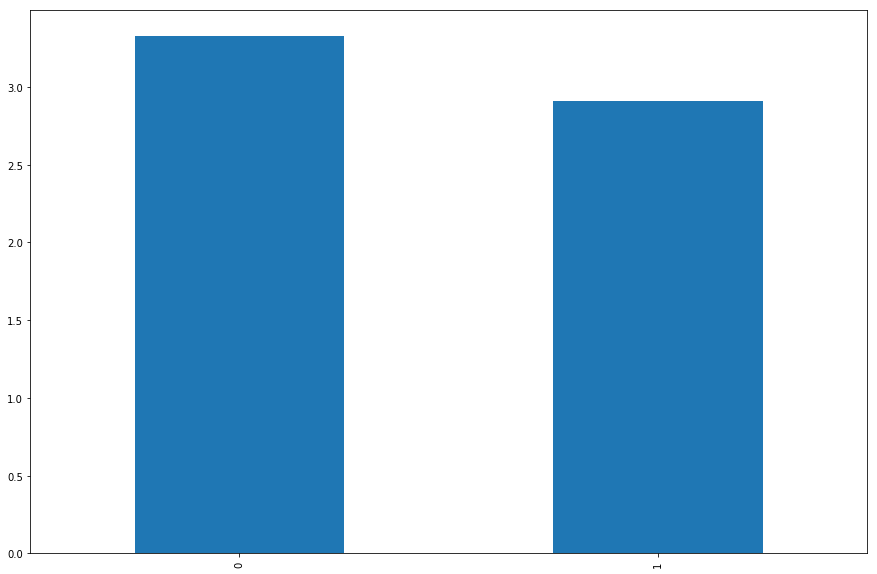

In [35]:
print("Median ARPU is equal to ",f.groupby("is_VOD_only")['revenue'].median())
print("..")
print("Mean ARPU is equal to ",f.groupby("is_VOD_only")['revenue'].mean())
temp = pd.DataFrame(f.groupby("is_VOD_only")['revenue'].median().reset_index())

temp['revenue'].plot(kind = 'bar',figsize = (15,10))

In [36]:
#f[f['encrypted_customer_id'] == 'A103FMTAYCVWMG']
f[f['encrypted_customer_id'] == 'A00043421QDCKJEKE0BY1']


,transaction_date,encrypted_customer_id,units,rank,content_type,marketplace_id,revenue,is_VOD_only,max_rank,first_date,...,diff_vs_third,diff_vs_fourth,diff_vs_fifth,diff_vs_sixth,diff_vs_seventh,diff_vs_eighth,diff_vs_ninth,diff_vs_tenth,diff_vs_eleventh,last2from_repeat


In [37]:
def find_first_date_within_group(df):
    """returns the first date within group """
    #Make subset
    subset_EST = df[(df['content_type'].isin(['Movie EST','TV Episode','TV Season'])) & (df['is_VOD_only'] == 0)]
    
    t = subset_EST.loc[subset_EST.groupby('encrypted_customer_id').transaction_date.idxmin()]
    #t['diff_btw_first_EST_first_ever'] = (t['transaction_date'] - t['first_purchase']) / np.timedelta64(1,"D")
    return t

In [38]:
est = find_first_date_within_group(f)

In [39]:
est.shape

(297547, 32)

In [40]:
est[est['encrypted_customer_id'] == 'A00043421QDCKJEKE0BY1'].iloc[:,0:25]

,transaction_date,encrypted_customer_id,units,rank,content_type,marketplace_id,revenue,is_VOD_only,max_rank,first_date,...,seven_date,eighth_date,ninth_date,tenth_date,eleventh_date,diff_vs_first,diff_vs_second,diff_vs_third,diff_vs_fourth,diff_vs_fifth


In [41]:
print(est['encrypted_customer_id'].nunique())
print(est.shape)
est.head()

297547
(297547, 32)


,transaction_date,encrypted_customer_id,units,rank,content_type,marketplace_id,revenue,is_VOD_only,max_rank,first_date,...,diff_vs_third,diff_vs_fourth,diff_vs_fifth,diff_vs_sixth,diff_vs_seventh,diff_vs_eighth,diff_vs_ninth,diff_vs_tenth,diff_vs_eleventh,last2from_repeat
4785088,2015-05-22,A0002198B6IYRDISY2WV,1,2,TV Season,3,2.08,0,49,2014-12-25,...,-2.0,-10.0,-26.0,-108.0,-110.0,-144.0,-178.0,-292.0,-305.0,0.08
516899,2014-12-21,A00037301XUUKEGFX3P8U,1,6,Movie EST,3,9.99,0,6,2014-12-05,...,13.0,7.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.99
3316326,2017-02-19,A00041461Q3D5CMQJ6DBH,1,5,Movie EST,3,3.33,0,27,2016-12-06,...,42.0,29.0,0.0,-54.0,-58.0,-85.0,-102.0,-132.0,-140.0,0.33
1822982,2015-07-13,A000525817I4PETQ5KQ1F,2,6,TV Season,3,28.32,0,16,2015-05-20,...,43.0,25.0,8.0,0.0,-2.0,-18.0,-25.0,-66.0,-135.0,0.32
6250486,2016-09-22,A00094902ESN16EFBTE5W,1,2,TV Season,3,18.74,0,9,2016-09-17,...,-213.0,-219.0,-311.0,-349.0,-543.0,-544.0,-559.0,0.0,0.0,0.74


# Build a matrix for ARPU

In [42]:
tt = pd.DataFrame(est.groupby("rank").size().reset_index())
tt.columns = ['rank','size']

In [43]:
print(tt['size'].sum())
tt[0:10]

297547


,rank,size
0,1,24465
1,2,127311
2,3,55010
3,4,29698
4,5,17931
5,6,11326
6,7,7700
7,8,5479
8,9,3970
9,10,2973


In [44]:
def rank_for_est(df,rank):
    """subset from est dataset and tells the index of the EST purchase ie how many VOD were bought before"""
    return df[df['rank'] == rank]


def buckets_per_rank(df,df_all,rank,column):
    #Make a call to previous function
    ranked = rank_for_est(df,rank)
        
    p_before = df_all[(df_all['encrypted_customer_id'].isin(ranked['encrypted_customer_id'])) 
               & (df_all['rank'] < int(ranked['rank'].unique()))]
   
    p_after = df_all[(df_all['encrypted_customer_id'].isin(ranked['encrypted_customer_id'])) 
               & (df_all['rank'] >= int(ranked['rank'].unique()))]
    
    #Create data set for revenue before first EST
    p_before_min = pd.DataFrame(p_before.groupby("encrypted_customer_id")['transaction_date'].min().reset_index())
    p_before_max = pd.DataFrame(p_before.groupby("encrypted_customer_id")['transaction_date'].max().reset_index())
    
    revenue_before = pd.DataFrame(p_before.groupby("encrypted_customer_id")['revenue'].sum().reset_index())
    m_before = pd.merge(left=revenue_before,right=p_before_min,left_on='encrypted_customer_id',
                 right_on='encrypted_customer_id', how="left")
    m_before = pd.merge(left=m_before,right=p_before_max,left_on='encrypted_customer_id',
                        right_on='encrypted_customer_id',how='left')
    m_before.columns = ['encrypted_customer_id','revenue','min_date','max_date']
    m_before['time_diff'] = (m_before['max_date'] - m_before['min_date']) / np.timedelta64(1,"D")
    m_before['time_diff_in_month'] = m_before['time_diff']/30.0
    m_before['rank'] = rank - 1
    m_before['time_diff_in_month'] = m_before['time_diff_in_month'].replace(0,1)
    m_before['time_diff_in_month'] = np.where(m_before['time_diff_in_month'] < 1, 1, m_before['time_diff_in_month'])
    
    
    #Create data set for revenue after first EST
    p_after_min = pd.DataFrame(p_after.groupby("encrypted_customer_id")['transaction_date'].min().reset_index())
    p_after_max = pd.DataFrame(p_after.groupby("encrypted_customer_id")['transaction_date'].max().reset_index())
    revenue_after = pd.DataFrame(p_after.groupby("encrypted_customer_id")['revenue'].sum().reset_index())
    m_after = pd.merge(left=revenue_after,right=p_after_min,left_on='encrypted_customer_id',
                 right_on='encrypted_customer_id', how="left")
    m_after = pd.merge(left=m_after,right=p_after_max,left_on='encrypted_customer_id',
                        right_on='encrypted_customer_id',how='left')
    
    m_after.columns = ['encrypted_customer_id','revenue','min_date','max_date']
    m_after['up_to_day'] = pd.to_datetime(datetime.date.today())
    m_after['time_diff_minmax'] = (m_after['max_date'] - m_after['min_date']) / np.timedelta64(1,"D")
    m_after['time_diff_up_today'] = (m_after['up_to_day'] - m_after['min_date']) / np.timedelta64(1,"D")
    m_after['time_diff_up_today_in_month'] = m_after['time_diff_up_today']/30.0
    
    m_after['time_diff_up_today_in_month'] = m_after['time_diff_up_today_in_month'].replace(0,1)
    
    
    ranked  = set_buckets(ranked,column)
    tt = pd.DataFrame(ranked.groupby("buckets").size().reset_index())
    tt.columns = ['buckets','size']
    tt['name'] = rank
    return tt,m_before,m_after
    

## Make it per rank

In [45]:
rank2, p2_before, p2_after = buckets_per_rank(est,f,2,"diff_vs_first")
print(rank2['size'].sum())

C:\Users\dfadeeff\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


127311


In [46]:
p2_before.head()

,encrypted_customer_id,revenue,min_date,max_date,time_diff,time_diff_in_month,rank
0,A0002198B6IYRDISY2WV,2.08,2014-12-25,2014-12-25,0.0,1.0,1
1,A00094902ESN16EFBTE5W,5.82,2016-09-17,2016-09-17,0.0,1.0,1
2,A00103703NTUL44ABXVGD,2.91,2014-12-15,2014-12-15,0.0,1.0,1
3,A00111021WOBMS5JW7FPR,3.74,2015-10-24,2015-10-24,0.0,1.0,1
4,A00138303SAUV9X1GBNQS,1.24,2015-12-03,2015-12-03,0.0,1.0,1


In [47]:
print((p2_before['revenue'] / p2_before['time_diff_in_month']).mean())
print((p2_after['revenue'] / p2_after['time_diff_up_today_in_month']).mean())

2.9964715539087807
4.20233081116385


In [48]:
rank3, p3_before, p3_after = buckets_per_rank(est,f,3,"diff_vs_second")
print(rank3['size'].sum())

C:\Users\dfadeeff\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


55010


In [49]:
p3_before.head()

,encrypted_customer_id,revenue,min_date,max_date,time_diff,time_diff_in_month,rank
0,A00296222TCQPLA00NO5H,7.45,2016-02-03,2016-09-14,224.0,7.466667,2
1,A0048658U0WCOJJ5G440,4.99,2015-06-06,2016-05-12,341.0,11.366667,2
2,A00770851VSB8YLD8D8A2,4.57,2017-04-15,2017-06-02,48.0,1.600000,2
3,A0079681MBWLP5843WKW,4.16,2014-05-21,2014-05-27,6.0,1.000000,2
4,A00842613PWTE79MHPU33,10.33,2016-08-26,2016-08-27,1.0,1.000000,2


In [50]:
print((p3_before['revenue'] / p3_before['time_diff_in_month']).mean())
print((p3_after['revenue'] / p3_after['time_diff_up_today_in_month']).mean())

4.15478363338418
4.851926092747766


In [51]:
rank4,p4_before, p4_after = buckets_per_rank(est,f,4,"diff_vs_third")
print(rank4['size'].sum())

C:\Users\dfadeeff\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


29698


In [52]:
print((p4_before['revenue'] / p4_before['time_diff_in_month']).mean())
print((p4_after['revenue'] / p4_after['time_diff_up_today_in_month']).mean())

4.72047762360868
5.237639857915038


In [53]:
rank5, p5_before, p5_after = buckets_per_rank(est,f,5,"diff_vs_fourth")
print(rank5['size'].sum())

C:\Users\dfadeeff\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


17931


In [54]:
print((p5_before['revenue'] / p5_before['time_diff_in_month']).mean())
print((p5_after['revenue'] / p5_after['time_diff_up_today_in_month']).mean())

4.9426090958672
5.548489662636946


In [55]:
rank6, p6_before, p6_after = buckets_per_rank(est,f,6,"diff_vs_fifth")
print(rank6['size'].sum())

C:\Users\dfadeeff\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


11326


In [56]:
print((p6_before['revenue'] / p6_before['time_diff_in_month']).mean())
print((p6_after['revenue'] / p6_after['time_diff_up_today_in_month']).mean())

5.277815310987685
5.8656904014891325


In [57]:
rank7, p7_before, p7_after = buckets_per_rank(est,f,7,"diff_vs_sixth")
print(rank7['size'].sum())

C:\Users\dfadeeff\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


7700


In [58]:
print((p7_before['revenue'] / p7_before['time_diff_in_month']).mean())
print((p7_after['revenue'] / p7_after['time_diff_up_today_in_month']).mean())

5.381817741080261
6.01954738293272


In [59]:
rank8, p8_before, p8_after = buckets_per_rank(est,f,8,"diff_vs_seventh")
print(rank8['size'].sum())

C:\Users\dfadeeff\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


5479


In [60]:
print((p8_before['revenue'] / p8_before['time_diff_in_month']).mean())
print((p8_after['revenue'] / p8_after['time_diff_up_today_in_month']).mean())

5.374178651716411
6.558196993421749


In [61]:
rank9,p9_before, p9_after = buckets_per_rank(est,f,9,"diff_vs_eighth")
print(rank9['size'].sum())

3970


C:\Users\dfadeeff\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [62]:
print((p9_before['revenue'] / p9_before['time_diff_in_month']).mean())
print((p9_after['revenue'] / p9_after['time_diff_up_today_in_month']).mean())

5.4130098489859755
6.39537245047367


In [63]:
rank10, p10_before, p10_after = buckets_per_rank(est,f,10,"diff_vs_ninth")
print(rank10['size'].sum())

C:\Users\dfadeeff\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


2973


In [64]:
print((p10_before['revenue'] / p10_before['time_diff_in_month']).mean())
print((p10_after['revenue'] / p10_after['time_diff_up_today_in_month']).mean())

5.341640054578872
6.684284550397199


In [65]:
rank11,p11_before, p11_after = buckets_per_rank(est,f,11,"diff_vs_tenth")
print(rank11['size'].sum())

C:\Users\dfadeeff\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


2137


In [66]:
print((p11_before['revenue'] / p11_before['time_diff_in_month']).mean())
print((p11_after['revenue'] / p11_after['time_diff_up_today_in_month']).mean())

5.615001408180712
6.82716854228857


In [67]:
list_new = [rank2,rank3,rank4,rank5,rank6,rank7,rank8,rank9,rank10,rank11]

In [68]:
fo = open("UK_EST_after_VOD.csv", 'w+')
for i in list_new:
    i.to_csv(fo)
fo.close()

### Distribution of units purchased by mixed class

In [69]:
t = pd.DataFrame(f[f['is_VOD_only']==0].groupby("content_type")['units'].sum().reset_index())
t['total'] = f[f['is_VOD_only']==0]['units'].sum()
t['share'] = t['units'] / t['total']

In [71]:
t

,content_type,units,total,share
0,Movie EST,1325610,6403968,0.206998
1,Movie VOD,3477899,6403968,0.543085
2,TV Episode,1068748,6403968,0.166888
3,TV Season,513004,6403968,0.080107
4,Unknown,18707,6403968,0.002921


In [77]:
np.exp(np.log(3) + 3*np.log(2))

23.999999999999993